In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set paths to your dataset folders
train_dir = '/home/esidserver/datasets/testing_cls/training-v2/train/'
val_dir = '/home/esidserver/datasets/testing_cls/training-v2/val/'
test_dir = '/home/esidserver/datasets/testing_cls/training-v2/test/'

# Image data generator with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data generator for validation and test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Data loaders
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for confusion matrix
)

# Load the ResNet-50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet50_best_model.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    train_generator,
    epochs=250,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint]
)

# Fine-tuning: Unfreeze some layers of the base model
for layer in base_model.layers:
    layer.trainable = True

# Compile the model again
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training with fine-tuning
history_finetune = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint]
)




2024-09-18 16:43:38.790319: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-18 16:43:38.815134: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-18 16:43:38.861896: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-18 16:43:38.870537: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-18 16:43:38.902148: I tensorflow/core/platform/cpu_feature_guar

Found 5193 images belonging to 4 classes.
Found 1484 images belonging to 4 classes.
Found 740 images belonging to 4 classes.


2024-09-18 16:43:42.052506: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22453 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


Epoch 1/250


/home/esidserver/miniforge3/envs/tf/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726652635.220933 2014790 service.cc:146] XLA service 0x78fdac04b9f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726652635.220989 2014790 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-09-18 16:43:55.568468: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-18 16:43:56.871623: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
2

  1/163 ━━━━━━━━━━━━━━━━━━━━ 45:30 17s/step - accuracy: 0.1875 - loss: 1.5210

I0000 00:00:1726652642.385309 2014790 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


116/163 ━━━━━━━━━━━━━━━━━━━━ 18s 384ms/step - accuracy: 0.2679 - loss: 1.3976

2024-09-18 16:44:49.522516: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5687', 12 bytes spill stores, 12 bytes spill loads



162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.2746 - loss: 1.3916

2024-09-18 16:45:19.703685: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1719', 12 bytes spill stores, 12 bytes spill loads



163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 506ms/step - accuracy: 0.2750 - loss: 1.3914 - val_accuracy: 0.4319 - val_loss: 1.3234
Epoch 2/250
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 393ms/step - accuracy: 0.3829 - loss: 1.3283 - val_accuracy: 0.4663 - val_loss: 1.2660
Epoch 3/250
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 398ms/step - accuracy: 0.4122 - loss: 1.2869 - val_accuracy: 0.4299 - val_loss: 1.2575
Epoch 4/250
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 403ms/step - accuracy: 0.4298 - loss: 1.2591 - val_accuracy: 0.5236 - val_loss: 1.1936
Epoch 5/250
163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 372ms/step - accuracy: 0.4484 - loss: 1.2328 - val_accuracy: 0.5047 - val_loss: 1.1622
Epoch 6/250
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 365ms/step - accuracy: 0.4558 - loss: 1.2050 - val_accuracy: 0.4926 - val_loss: 1.1580
Epoch 7/250
163/163 ━━━━━━━━━━━━━━━━━━━━ 61s 359ms/step - accuracy: 0.4452 - loss: 1.1990 - val_accuracy: 0.4987 - val_loss: 1.1414
Epoch 8/250
163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 369ms/step - accuracy: 0.4468 - loss: 1.185

2024-09-18 20:57:25.724989: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_15690', 76 bytes spill stores, 76 bytes spill loads



163/163 ━━━━━━━━━━━━━━━━━━━━ 173s 643ms/step - accuracy: 0.3646 - loss: 55.1978 - val_accuracy: 0.2406 - val_loss: 18.0978
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 60s 353ms/step - accuracy: 0.7711 - loss: 1.7019 - val_accuracy: 0.2487 - val_loss: 50.3445
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 61s 362ms/step - accuracy: 0.8241 - loss: 0.9426 - val_accuracy: 0.2466 - val_loss: 36.5525
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 61s 356ms/step - accuracy: 0.8604 - loss: 0.5930 - val_accuracy: 0.2487 - val_loss: 36.2223
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 379ms/step - accuracy: 0.8902 - loss: 0.4337 - val_accuracy: 0.3322 - val_loss: 15.4449
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 60s 353ms/step - accuracy: 0.8915 - loss: 0.4097 - val_accuracy: 0.6226 - val_loss: 3.2327
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 61s 362ms/step - accuracy: 0.9238 - loss: 0.2795 - val_accuracy: 0.8544 - val_loss: 0.5977
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 370ms/step - accuracy: 0.9300 - loss

In [2]:

# Evaluate on the validation set
val_loss, val_acc = model.evaluate(val_generator)
print(f"Final Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")

# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# Save the final model
model.save('resnet50_final_model.keras')

47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.9859 - loss: 0.0250 
Final Validation Accuracy: 0.9879, Validation Loss: 0.0324
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8655 - loss: 0.8443

2024-09-18 22:40:06.311816: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1719', 4 bytes spill stores, 4 bytes spill loads



24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 284ms/step - accuracy: 0.8698 - loss: 0.8238
Test Accuracy: 0.9189, Test Loss: 0.5884


24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 279ms/step


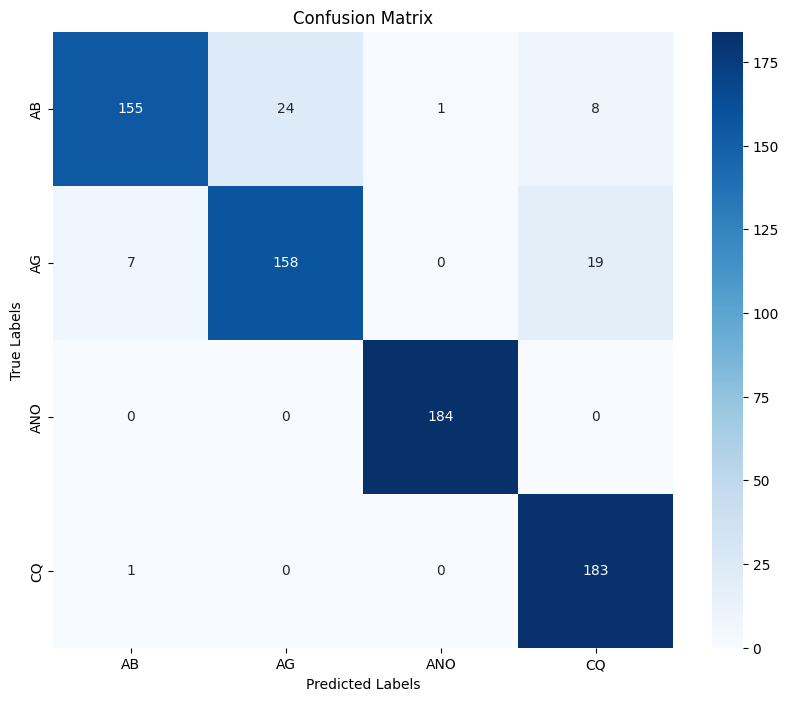

Classification Report:
              precision    recall  f1-score   support

          AB       0.95      0.82      0.88       188
          AG       0.87      0.86      0.86       184
         ANO       0.99      1.00      1.00       184
          CQ       0.87      0.99      0.93       184

    accuracy                           0.92       740
   macro avg       0.92      0.92      0.92       740
weighted avg       0.92      0.92      0.92       740



: 

In [3]:
# Generate predictions for the test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
cm_labels = list(test_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=cm_labels, yticklabels=cm_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report for precision, recall, f1-score
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=cm_labels))